# Introduction

In this notebook, I will be leveraging foursquare location data to explore venues districts in Delhi, India. This will give me insights of what most popular venues are there in each district and the quantity/quality of data that Foursquare has of India.

#### Import required libraries

In [1]:
import requests

from bs4 import BeautifulSoup

import pandas as pd

import numpy as np

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

On exploring internet, I found a blog which has information on all the PostalCodes of Delhi, which mentions district and corresponding neighborhoods as well. I will be reading the required information from the website. 
www.whatsuplife.in/delhi/blog/zip-pin-postal-code-pincodes-delhi

In [ ]:
# Read the HTML page
reponse = requests.get('https://www.whatsuplife.in/delhi/blog/zip-pin-postal-code-pincodes-delhi')
soup = BeautifulSoup(reponse.content, 'html.parser')

Get all the Districts

In [3]:
headings = soup.findAll("h4")
districts = []
for heading in headings:
     if heading.findParent("h4") is None:
        districts.append(str(heading.text).replace(u'\xa0', u' '))
districts

['CENTRAL DELHI',
 'SOUTH DELHI',
 'WEST DELHI',
 'NORTH DELHI',
 'EAST DELHI',
 'SOUTH WEST DELHI',
 'NORTH WEST DELHI']

In [8]:
# Define the delhi dataframe
delhi_df = pd.DataFrame(columns=['District','Neighborhood', 'PostalCode'])

Read all the districts, postal codes and corresponding neighborhoods from the HTML

In [9]:
tables = soup.findAll("table")
for table, district in zip(tables, districts):
    trs = table.find_all('tr')
    trs = [tr for tr in trs if len(tr.find_all('td')) == 2]
    neighborhoods = []
    postalcodes = []
    dis = []
    for tr in trs:
        tds = tr.find_all('td')
        postalcodes.append(tds[1].text)
        neighborhoods.append(tds[0].text)
        dis.append(district)
    df = pd.DataFrame(list(zip(dis, neighborhoods, postalcodes)), columns=['District','Neighborhood', 'PostalCode'])
    delhi_df = delhi_df.append(df)
    
print("The shape of delhi dataframe ", delhi_df.shape)

The shape of delhi dataframe  (425, 3)


In [10]:
# Read first five rows
delhi_df.head()

,District,Neighborhood,PostalCode
0,CENTRAL DELHI,A.G.c.r.,110002
1,CENTRAL DELHI,A.K.market,110055
2,CENTRAL DELHI,Ajmeri Gate extn.,110002
3,CENTRAL DELHI,Anand Parbat,110005
4,CENTRAL DELHI,Anand Parbat indl. area,110005


As you can see above, there are mulitple neighborhoods in same PostalCode and same District.

Below I will check the unique counts of each

In [11]:
delhi_df.describe()

,District,Neighborhood,PostalCode
count,425,425,425
unique,7,424,84
top,SOUTH DELHI,Shivaji Park,110001
freq,77,2,19


So there are 7 Unique Districts, 424 Unique Neighborhoods and 84 Unique PostalCodes

Now lets join the neihborhoods, based on common PostalCode so that we have list of neighborhoods in one cell that correspond to a PostalCode

In [14]:
strjoin = lambda x: ', '.join(set(x))
agg_functions = {'District': 'first', 'Neighborhood': strjoin, 'PostalCode': 'first'}
agg_functions

{'District': 'first',
 'Neighborhood': <function __main__.<lambda>(x)>,
 'PostalCode': 'first'}

In [16]:
delhi_cleaned_df = delhi_df.groupby(delhi_df['PostalCode']).aggregate(agg_functions)
delhi_cleaned_df = delhi_cleaned_df.reset_index(drop=True)
delhi_cleaned_df.head()

,District,Neighborhood,PostalCode
0,CENTRAL DELHI,"Connaught Place, Bengali Market, Janpath, Nort...",110001
1,CENTRAL DELHI,"Indraprastha, Gandhi Smarak nidhi, Darya Ganj,...",110002
2,CENTRAL DELHI,"Pandara Road, Pragati Vihar, Delhi High court,...",110003
3,CENTRAL DELHI,Rashtrapati Bhawan,110004
4,CENTRAL DELHI,"Bank Street, Sat Nagar, Desh Bandhu gupta road...",110005


Check again for unique counts

In [17]:
delhi_cleaned_df.describe()

,District,Neighborhood,PostalCode
count,84,84,84
unique,7,84,84
top,SOUTH WEST DELHI,"Daulatpur, Baprola, Dichaoal Kalan, Dulsiras, ...",110062
freq,22,1,1


I will use Nominatim library to get Latitude, Longitude of each PostalCode in Delhi

In [18]:
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('Delhi, India')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6517178, 77.2219388.


In [ ]:
# Since this does not work all the time, it is better to save the data when successfully retrieved.
from time import sleep

def get_lat_lon(postal_code):
    location = locator.geocode('{}, Delhi, India'.format(postal_code))
    sleep(2)
    return (location.latitude, location.longitude)

ll_df = pd.DataFrame(columns=['PostalCode', 'Latitude', 'Longitude'])

pcodes = []
lat_list = []
lon_list = []

for postal_code in delhi_cleaned_df['PostalCode']:
    lat, lon = get_lat_lon(postal_code)
    pcodes.append(postal_code)
    lat_list.append(lat)
    lon_list.append(lon)

In [ ]:
ll_df['PostalCode'] = pcodes
ll_df['Latitude'] = lat_list
ll_df['Longitude'] = lon_list

In [32]:
#if above is not a success
ll_df = pd.read_csv('Postcode_lat_lon.csv', index_col=0)
ll_df.head()

,PostalCode,Latitude,Longitude
0,110002,28.640964,77.245468
1,110055,28.652506,77.213391
2,110005,28.650529,77.189018
3,110001,28.651718,77.221939
4,110008,28.656175,77.162460


Add these to delhi dataframe

In [37]:
delhi_cleaned_df['PostalCode'] = delhi_cleaned_df.PostalCode.astype(int)

In [38]:
delhi_cleaned_df = delhi_cleaned_df.join(ll_df.set_index('PostalCode'), on='PostalCode')

In [39]:
delhi_cleaned_df.head()

,District,Neighborhood,PostalCode,Latitude,Longitude
0,CENTRAL DELHI,"Connaught Place, Bengali Market, Janpath, Nort...",110001,28.651718,77.221939
1,CENTRAL DELHI,"Indraprastha, Gandhi Smarak nidhi, Darya Ganj,...",110002,28.640964,77.245468
2,CENTRAL DELHI,"Pandara Road, Pragati Vihar, Delhi High court,...",110003,28.598731,77.222996
3,CENTRAL DELHI,Rashtrapati Bhawan,110004,28.616082,77.204501
4,CENTRAL DELHI,"Bank Street, Sat Nagar, Desh Bandhu gupta road...",110005,28.650529,77.189018


Save this file to use in Part 2

In [40]:
delhi_cleaned_df.to_csv("Delhi.csv")

In [52]:
delhi_cleaned_df.groupby('District')['District'].count()

District
CENTRAL DELHI       12
EAST DELHI          10
NORTH DELHI          3
NORTH WEST DELHI    14
SOUTH DELHI         13
SOUTH WEST DELHI    22
WEST DELHI          10
Name: District, dtype: int64

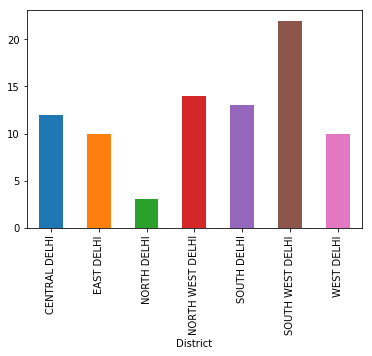

In [54]:
delhi_cleaned_df.groupby('District')['District'].count().plot.bar()

Create a map of delhi with all the postalcodes/neighborhoods

In [55]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district, neighborhood in zip(delhi_cleaned_df['Latitude'], delhi_cleaned_df['Longitude'], delhi_cleaned_df['District'], delhi_cleaned_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

I will be using the above obtained data to figure out the venue data that foursquare has and can we find some insights among different districts of Delhi.